=== Base case: no new lines allowed ===
Status: optimal
Objective: 20000.0
Total slack: 200.0

=== Expansion case: investment allowed ===
Status: optimal
Objective: 20000.0
Total slack: 200.0

Build decisions (expansion case):
C01 (0-2): y = 0
C02 (4-6): y = 0
C03 (1-3): y = 0
C04 (2-5): y = 0
C05 (5-7): y = -0


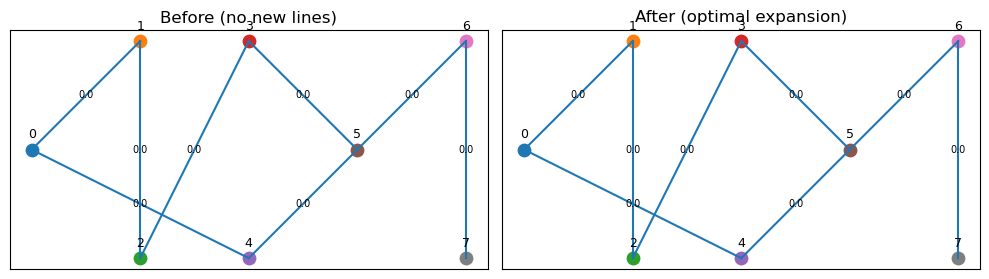

In [11]:
from pyscipopt import Model, quicksum
import matplotlib.pyplot as plt

# ==========================================
# Data
# ==========================================

# Buses
buses = list(range(8))
ref_bus = 0  # reference for angle

# Net injections: separate generation and demand
# Two generators at buses 0 and 4
gen = {i: 0.0 for i in buses}
gen[0] = 60.0
gen[4] = 40.0

dem = {i: 0.0 for i in buses}
dem[1] = 20.0
dem[2] = 20.0
dem[3] = 15.0
dem[5] = 15.0
dem[6] = 15.0
dem[7] = 15.0
# total gen = 100, total demand = 100

# Existing lines: (name, from, to, capacity, susceptance)
existing_lines = [
    ("L01", 0, 4, 100.0, 10.0),  # strong tie between generators
    ("L02", 0, 1, 30.0, 10.0),   # cross cut, limited
    ("L03", 4, 5, 20.0, 10.0),   # cross cut, limited
    ("L04", 1, 2, 40.0, 10.0),
    ("L05", 2, 3, 40.0, 10.0),
    ("L06", 3, 5, 40.0, 10.0),
    ("L07", 5, 6, 40.0, 10.0),
    ("L08", 6, 7, 40.0, 10.0),
]

# Candidate lines: (name, from, to, capacity, susceptance, invest_cost)
# First two cross the generator-load cut and are really helpful;
# the others are "internal" and not strictly needed.
candidate_lines = [
    ("C01", 0, 2, 40.0, 10.0, 4000.0),  # cross cut, important
    ("C02", 4, 6, 40.0, 10.0, 4500.0),  # cross cut, important
    ("C03", 1, 3, 20.0, 10.0, 1500.0),  # internal load area, less useful
    ("C04", 2, 5, 20.0, 10.0, 1500.0),  # internal load area
    ("C05", 5, 7, 20.0, 10.0, 1500.0),  # internal load area
]

# Big penalty on absolute slack (load shedding or spillage)
shed_cost = 100.0


# ==========================================
# Helper: build & solve model
# ==========================================

def build_and_solve(allow_invest=True):
    """
    Build and solve the transmission expansion model.

    If allow_invest=False, all candidate lines are forced y=0 (base case).
    If allow_invest=True, model chooses which candidate lines to build.
    """
    m = Model("transmission_capexp")

    # Indices
    nB = len(buses)
    nE = len(existing_lines)
    nC = len(candidate_lines)

    # ------------- Variables -------------

    # Voltage angles
    theta = {i: m.addVar(lb=None, ub=None, name=f"theta({i})") for i in buses}

    # Flows on existing lines
    fE = {ell: m.addVar(lb=0.0, ub=None, name=f"fE({ell})") for ell in range(nE)}

    # Flows on candidate lines
    fC = {k: m.addVar(lb=0.0, ub=None, name=f"fC({k})") for k in range(nC)}

    # Build decisions
    y = {}
    for k in range(nC):
        if allow_invest:
            y[k] = m.addVar(vtype="B", name=f"y({k})")
        else:
            # base case: no investment allowed
            y[k] = m.addVar(vtype="B", lb=0.0, ub=0.0, name=f"y({k})")

    # Slack variables: s_plus - s_minus = net mismatch at each bus
    # (positive = load shed, negative = spill)
    s_plus  = {i: m.addVar(lb=0.0, name=f"s_plus({i})") for i in buses}
    s_minus = {i: m.addVar(lb=0.0, name=f"s_minus({i})") for i in buses}

    # ------------- Constraints -------------

    # Reference bus angle
    m.addCons(theta[ref_bus] == 0.0, name="ref_bus")

    # DC flows on existing lines
    for ell, (name, i, j, cap, B) in enumerate(existing_lines):
        m.addCons(
            fE[ell] == B * (theta[i] - theta[j]),
            name=f"DC_existing_{name}"
        )
        # Capacity limits
        m.addCons(fE[ell] <= cap,   name=f"cap_pos_{name}")
        m.addCons(fE[ell] >= -cap,  name=f"cap_neg_{name}")

    # DC flows on candidate lines + on/off with y
    for k, (name, i, j, cap, B, invcost) in enumerate(candidate_lines):
        m.addCons(
            fC[k] == B * (theta[i] - theta[j]),
            name=f"DC_candidate_{name}"
        )
        # Line exists only if y_k = 1
        m.addCons(fC[k] <= cap * y[k],  name=f"cap_pos_{name}")
        m.addCons(fC[k] >= -cap * y[k], name=f"cap_neg_{name}")

    # Nodal power balance for each bus
    for i in buses:
        inflow = []
        outflow = []

        # existing lines
        for ell, (name, a, b, cap, B) in enumerate(existing_lines):
            if a == i:
                outflow.append(fE[ell])
            elif b == i:
                inflow.append(fE[ell])

        # candidate lines
        for k, (name, a, b, cap, B, invcost) in enumerate(candidate_lines):
            if a == i:
                outflow.append(fC[k])
            elif b == i:
                inflow.append(fC[k])

        # power balance: gen - dem + slack = net outflow
        m.addCons(
            gen[i] - dem[i] + s_plus[i] - s_minus[i]
            == sum(inflow) - sum(outflow),
            name=f"balance({i})"
        )

    # ------------- Objective -------------
    # Minimize investment + absolute load shedding/spillage

    invest_cost_term = quicksum(
        candidate_lines[k][5] * y[k] for k in range(nC)
    )

    slack_cost_term = shed_cost * quicksum(
        s_plus[i] + s_minus[i] for i in buses
    )

    m.setObjective(invest_cost_term + slack_cost_term, "minimize")

    # ------------- Solve -------------
    m.setParam("display/verblevel", 0)  # quiet
    m.optimize()

    status = m.getStatus()
    if status not in ["optimal", "bestsollimit"]:
        print("WARNING: solver status =", status)

    sol = m.getBestSol()

    # Extract solutions
    theta_sol = {i: sol[theta[i]] for i in buses}
    fE_sol = {ell: sol[fE[ell]] for ell in range(nE)}
    fC_sol = {k: sol[fC[k]] for k in range(nC)}
    y_sol  = {k: sol[y[k]] for k in range(nC)}
    splus_sol  = {i: sol[s_plus[i]] for i in buses}
    sminus_sol = {i: sol[s_minus[i]] for i in buses}

    obj_val = m.getObjVal()

    return {
        "status": status,
        "obj": obj_val,
        "theta": theta_sol,
        "fE": fE_sol,
        "fC": fC_sol,
        "y": y_sol,
        "splus": splus_sol,
        "sminus": sminus_sol,
    }


# ==========================================
# Solve base case and expansion case
# ==========================================

print("=== Base case: no new lines allowed ===")
res_base = build_and_solve(allow_invest=False)
print("Status:", res_base["status"])
print("Objective:", res_base["obj"])
print("Total slack:",
      sum(res_base["splus"][i] + res_base["sminus"][i] for i in buses))

print("\n=== Expansion case: investment allowed ===")
res_exp = build_and_solve(allow_invest=True)
print("Status:", res_exp["status"])
print("Objective:", res_exp["obj"])
print("Total slack:",
      sum(res_exp["splus"][i] + res_exp["sminus"][i] for i in buses))

print("\nBuild decisions (expansion case):")
for k, (name, i, j, cap, B, invcost) in enumerate(candidate_lines):
    print(f"{name} ({i}-{j}): y = {res_exp['y'][k]:.0f}")


# ==========================================
# Visualization: before vs after
# ==========================================

# Fixed positions for buses (just for nice drawing)
pos = {
    0: (0.0, 1.0),
    1: (1.0, 2.0),
    2: (1.0, 0.0),
    3: (2.0, 2.0),
    4: (2.0, 0.0),
    5: (3.0, 1.0),
    6: (4.0, 2.0),
    7: (4.0, 0.0),
}

def plot_network(ax, title, flows_existing, flows_candidate, y_build):
    # draw buses
    for i in buses:
        x, y = pos[i]
        ax.scatter(x, y, s=80)
        ax.text(x, y+0.08, f"{i}", ha="center", va="bottom", fontsize=9)

    # use same color for all lines
    line_color = "C0"

    # existing lines
    for ell, (name, i, j, cap, B) in enumerate(existing_lines):
        x1, y1 = pos[i]
        x2, y2 = pos[j]
        ax.plot([x1, x2], [y1, y2],
                color=line_color, linewidth=1.5)
        # label with flow
        flow = flows_existing[ell]
        xm, ym = (x1+x2)/2, (y1+y2)/2
        ax.text(xm, ym, f"{flow:.1f}",
                fontsize=7, ha="center", va="center")

    # candidate lines (only those with y_build ~ 1)
    for k, (name, i, j, cap, B, invcost) in enumerate(candidate_lines):
        if y_build is not None and y_build[k] > 0.5:
            x1, y1 = pos[i]
            x2, y2 = pos[j]
            ax.plot([x1, x2], [y1, y2],
                    color=line_color, linewidth=2.5, linestyle="--")
            flow = flows_candidate[k]
            xm, ym = (x1+x2)/2, (y1+y2)/2
            ax.text(xm, ym, f"{flow:.1f}",
                    fontsize=7, ha="center", va="center")

    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("equal", "box")


fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Before: base case, no candidates built
plot_network(
    axes[0],
    "Before (no new lines)",
    flows_existing=res_base["fE"],
    flows_candidate={k: 0.0 for k in range(len(candidate_lines))},
    y_build=None  # do not draw candidates
)

# After: expansion case, draw only built candidates
plot_network(
    axes[1],
    "After (optimal expansion)",
    flows_existing=res_exp["fE"],
    flows_candidate=res_exp["fC"],
    y_build=res_exp["y"],
)

plt.tight_layout()
plt.show()
